# Audio classification using the SummaryStats Pipeline

This is a tutorial on how to run the pipeline as shown in _Einstein et al_, "Introducing SummaryStats: the new pipeline for audio processing", Phys. Rev. Z, Sept. 1873

In [1]:
from audio_classifier.tune import get_train_test_split, tune, evaluate
from audio_classifier.seeds import set_all_seeds

from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In a virtual environment, install the dependencies:

```bash
pip install -r requirements.txt
```

Each audio recording should be a separate `.wav` file in a folder with the following format: `digit_name_instance.wav` where `digit` and `instance` are integers.

You can specify hyperparameters to optimize using the Scikit-Learn templates. The modules and parameters available for optimization:
```bash
summary_stats:
    n_mels
    n_fft
    hop_length
pca:
    n_components
classifier:
    n_neighbors
```
Other parameters of sklearn's PCA and KNeighborsClassifier are also open to optimization.

Below is the method used to generate our results

In [ ]:
set_all_seeds(0)

X_train, X_test, y_train, y_test = get_train_test_split('recordings')

# Define the hyperparameters for optimization
param_grid = {
        "summary_stats__n_mels" : np.array([32, 64]),
        "pca__n_components" : np.arange(16, 72, 4),
        "classifier__n_neighbors" : np.arange(1,24,1)
    }

tune(X_train, y_train, param_grid, output='searches/grid_search_3.joblib')

You can also load the pretrained searches, and use the best model to run inference on your own data:

In [6]:
search = load('searches/grid_search_3.joblib')
print(search.best_params_)

y_pred, acc = evaluate(X_test, y_test, search.best_estimator_)
print(f"Test Accuracy: {100*acc:.2f}%")

{'classifier__n_neighbors': 1, 'pca__n_components': 44, 'summary_stats__n_mels': 32}
Test Accuracy: 95.20%


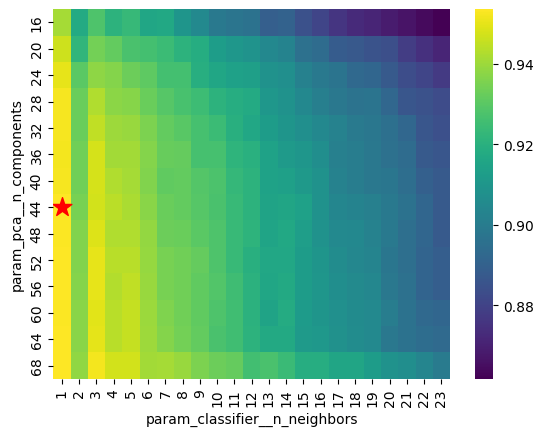

In [7]:
df = pd.DataFrame(search.cv_results_)

sns.heatmap(df.pivot_table(index="param_pca__n_components", columns="param_classifier__n_neighbors", values="mean_test_score"),fmt=".3f", cmap="viridis")
plt.scatter(np.where(param_grid['classifier__n_neighbors']==search.best_params_["classifier__n_neighbors"])[0]+0.5,
            np.where(param_grid['pca__n_components']==search.best_params_["pca__n_components"])[0]+0.5, 
            marker="*", s=200, c="r")
plt.show()